# Data Analysis Interview Challenge (Ultimate Inc.)

In [1]:
# Managing warnings
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import math

import json
from pandas.io.json import json_normalize

# Plot the Figures Inline
%matplotlib inline

In [2]:
## display option
pd.set_option('display.max_columns', None)

In [3]:
## missing values
missing_values = ['n/a', 'na', '-', '*']

# Part 1. Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute
time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [4]:
#timestamps of user logins in a particular geographic location
df_logins = pd.read_json('data/logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df_logins.shape

(93142, 1)

In [6]:
print("min time: {}".format(df_logins.login_time.min()))
print("max time: {}".format(df_logins.login_time.max()))

min time: 1970-01-01 20:12:16
max time: 1970-04-13 18:57:38


In [7]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [8]:
#Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex for using resample(), NOT RangeIndex
df_logins = df_logins.set_index('login_time')

In [9]:
# aggregate login counts based on 15-minute time intervals
df_logins['count_fifteenMin'] = 0
df_logins = df_logins.resample('15min').count()
df_logins.head()

,count_fifteenMin
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [10]:
#DatetimeIndex
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
count_fifteenMin    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


In [11]:
df_logins = df_logins.reset_index()

In [12]:
#RangeIndex
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 2 columns):
login_time          9788 non-null datetime64[ns]
count_fifteenMin    9788 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 153.0 KB


Visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles.

### Seasonal

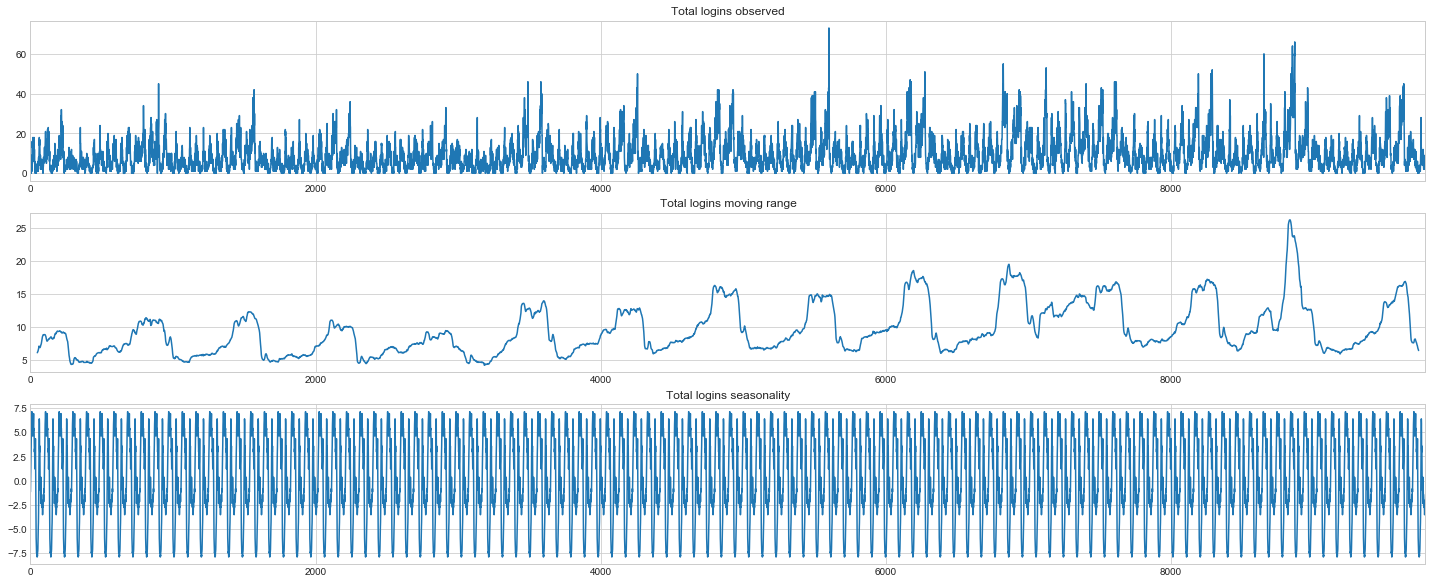

In [13]:
#Create a correlation plot of both datasets.
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 
season = seasonal_decompose(df_logins['count_fifteenMin'], model='additive', freq=96)

plt.subplot(3, 1, 1)
plt.title('Total logins observed')
season.observed.plot()

plt.subplot(3, 1, 2)
plt.title('Total logins moving range')
season.trend.plot()

plt.subplot(3, 1, 3)
plt.title('Total logins seasonality')
season.seasonal.plot()

It seems there are some patterns but it is hard to interpret. To look closer, the hourly and daily patterns of logins are investigated. 

### Week Day

In [14]:
# The day of the week with Monday=0, Sunday=6.
#df_logins['weekday']=df_logins['login_time'].dt.weekday #weekday = dayofweek (alias)
# names for ease of reference
#df_dayweek.weekday = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']


df_logins['weekday']=df_logins['login_time'].dt.day_name() #weekday = dayofweek (alias)
df_logins.head()

,login_time,count_fifteenMin,weekday
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday


In [15]:
# groupby('key', as_index=False): key does not become index but a column (no need reset_index() later)
df_dayweek = df_logins.groupby('weekday', as_index=False).sum()
df_dayweek

,weekday,count_fifteenMin
0,Friday,15208
1,Monday,8823
2,Saturday,19377
3,Sunday,18167
4,Thursday,11960
5,Tuesday,9268
6,Wednesday,10339


Text(0.5, 1.0, 'Logins by Day of Week')

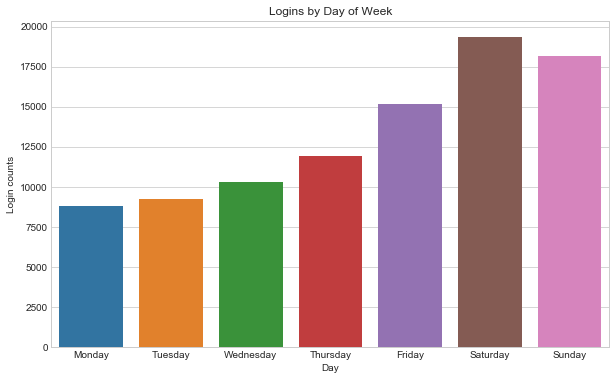

In [16]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,6)) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# bar plot
sns.barplot(x = 'weekday', y = 'count_fifteenMin', data = df_dayweek, order=weekday_order)
plt.xlabel('Day')
plt.ylabel('Login counts')
plt.title('Logins by Day of Week')

In [17]:
df_logins['hour'] = df_logins['login_time'].dt.hour
df_logins.head()

,login_time,count_fifteenMin,weekday,hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


In [18]:
df_hour = df_logins.groupby('hour', as_index=False).sum()
df_hour.head()

,hour,count_fifteenMin
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


Text(0.5, 1.0, 'Logins by Hour')

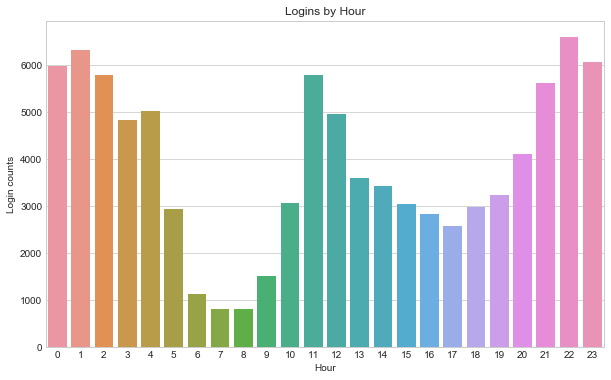

In [19]:
fig = plt.figure(figsize=(10,6))
# bar plot
sns.barplot(x = 'hour', y = 'count_fifteenMin', data = df_hour)
plt.xlabel('Hour')
plt.ylabel('Login counts')
plt.title('Logins by Hour')

In [20]:
# def dateplot(x, y, **kwargs):
#     ax = plt.gca()
#     data = kwargs.pop("data")
#     data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)
    
# g = sns.FacetGrid(df_logins, col="weekday", col_wrap=3, height=3.5)
# g = g.map_dataframe(dateplot, "hour", "count_fifteenMin")

In [21]:
df_day_hour = df_logins.groupby(['weekday','hour'], as_index=False).sum()
df_day_hour.head()

,weekday,hour,count_fifteenMin
0,Friday,0,975
1,Friday,1,957
2,Friday,2,771
3,Friday,3,502
4,Friday,4,353


* Pandas - How to group-by and plot for each hour of each day of week  
https://stackoverflow.com/questions/54856726/pandas-how-to-group-by-and-plot-for-each-hour-of-each-day-of-week

<Figure size 2016x1008 with 0 Axes>

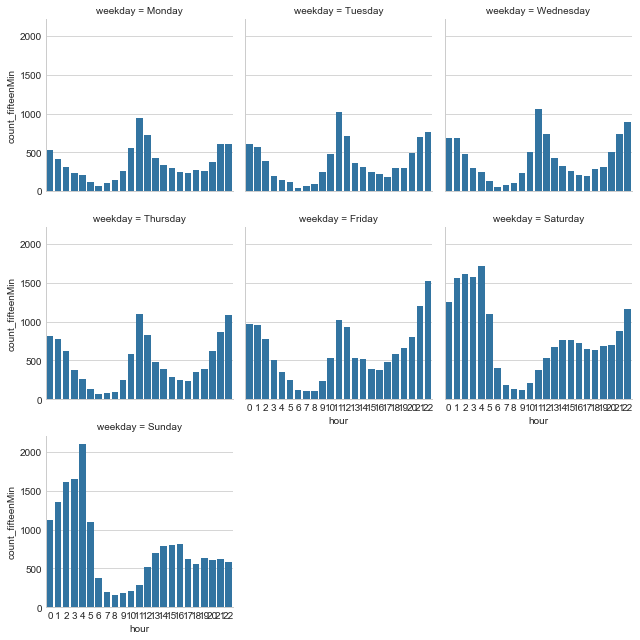

In [22]:
fig = plt.figure(figsize=(28,14))
g = sns.FacetGrid(df_day_hour, col="weekday", col_wrap=3, col_order=weekday_order)
g.map(sns.barplot, "hour", "count_fifteenMin", order=range(0,23))

## exact same approach
# g = sns.FacetGrid(data=df_logins.groupby(['weekday','hour']).count_fifteenMin.sum()
#                   .to_frame(name='day_hour_count').reset_index(), 
#                   col='weekday', 
#                   col_order=[
#     'Sunday',
#     'Monday',
#     'Tuesday',
#     'Wednesday',
#     'Thursday',
#     'Friday',
#     'Saturday'
# ], col_wrap=3)
# g.map(sns.barplot, 'hour', 'day_hour_count')

==> Summary:  

The logins most occur in Saturday and Sunday.

By investigating into hours, logins most occur at late night and  (21 ~ 2).
The logins start to increase from 21, peak at 22, decrease after 1.
During the lunch time (11 ~ 12), logins increase for a while.

**Combining weekdays and hours, we can see that most users log in most of the late nights and dawns on Sundays and Saturdays.**

# Part 2. Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?  

 ==> I want to investigate if the "encouraging driver partners (by reimbursing all toll costs)" is effective in servicing both cities.  
The most important key measure of success will be the **revenue increase** for the Ultimate Inc.
The higher the `increased revenue`, the experiment "encouraging driver partners to serve in both cities" can be considered to be more successful. Please note that the metrics are measured on before and after encouraging driver partners then the difference as the success indicator is obtained.
    - `increased revenue`: revenue (costs of toll reimbursement should be deducted)

 In the aspects of the servicing both cities, we can measure the following metrics that can be regarded to as successful indicators.

 - `increased number of available drivers`: average number of available drivers when calling for the pickup,  
 - `decreased wait time`: average wait time when calling for the pickup, and  
 - `increased number of trips`: number of trips across the bridges.


2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
  a. how you will implement the experiment  
  
 ==> To investigate the effectiveness of the proposed change, I would compare two groups of drivers with/without reimbursements and measure the key measures mentioned above.
I would recommend dividing the drivers at random by 50\% and 50\% for each group, 
one for the drivers offered reimbursement and the other for remaining drivers continuing to operate without being reimbursed for tolls. 

  b. what statistical test(s) you will conduct to verify the significance of the observation   
  
 ==> To verify the significance of the observation, I perform the A/B test on those two groups.
I perform the t-test with a confidence level of 95\%, where the null hypothesis is the reimbursing drivers for tolls does not have a statistically significant impact on Ultimate's net profits.

  c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.   
  
  ==> If the `increased revenue` is positive, then it is effective to encourage driver partners by reimbursing toll costs. If the `increased revenue` is negative, they should not adopt the toll cost reimbursement. Even it is revealed the `increased revenue` is positive, the drivers have randomly chosen, and it may not be effective in all cases. We need more rigorous experiments by different variables (e.g., selecting other drivers, differnt portions, different days, etc.)

# Part 3. Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.  

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention.

#### Data Description

● city: city this user signed up in  
● phone: primary device for this user  
● signup_date: date of account registration; in the form ‘YYYY MM DD’  
● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’  
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup  
● avg_rating_by_driver: the rider’s average rating over all of their trips  
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips  
● surge_pct: the percent of trips taken with surge multiplier > 1  
● avg_surge: The average surge multiplier over all of this user’s trips  
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up  
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise  
● weekday_pct: the percent of the user’s trips occurring during a weekday

## 1. Data Wrangling

In [23]:
#users = pd.read_json('data/ultimate_data_challenge.json') #pd.read_json failed
#Then, open file, load with normal "json.load", then load into a pandas dataframe

with open('data/ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [24]:
df.shape

(50000, 12)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### 1.1 Handling Missing Values

In [26]:
# check nulls : get index of null values and get dataframe
df[df['avg_rating_of_driver'].isnull()].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
6,3.95,4.0,NaN,1.0,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
9,2.37,5.0,NaN,1.0,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0
12,20.29,5.0,NaN,1.0,Winterfell,2014-03-12,iPhone,2014-01-15,0.0,1,False,100.0
14,26.01,5.0,NaN,1.0,Astapor,2014-01-28,Android,2014-01-27,0.0,1,False,100.0
15,13.20,5.0,NaN,1.0,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,True,100.0


In [27]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean()) #4.6
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].round(1)

df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean()) #4.8
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].round(1)

In [28]:
#df.phone.value_counts(normalize=True) #ratio
df['phone'] = df['phone'].fillna(df['phone'].mode().iloc[0]) #fill missing values for each column (using its own most frequent value)

### 1.2 Datetime Manipulation

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [30]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] =  pd.to_datetime(df['last_trip_date'])

In [31]:
earliest_signup = df.signup_date.min()
latest_signup = df.signup_date.max()
signups_ct = df.signup_date.count()
last_trip = df.last_trip_date.max()

print('There were {} signups between {} and {}'.format(signups_ct, earliest_signup, latest_signup))
print('Last trip: {}'.format(last_trip))

There were 50000 signups between 2014-01-01 00:00:00 and 2014-01-31 00:00:00
Last trip: 2014-07-01 00:00:00


### 1.3 Labeling and Deriving Features

We first need to clarity an active use and a retention user.

A user is identified as an active user (`active_user`) if he/she takes a trip ("active") in the 6th month on the system.

For identifying the retention user (`retention_user`), we do need to know the date when the data was pulled. You instructed users are retained if they were “active” (i.e. took a trip) in the preceding 30 days (from the date when the data was pulled).
But, we do not know the exact date, so we regard the maximum `last_trip_date` as the baseline.

As defined in the instruction, we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

In [32]:
from datetime import date
from dateutil.relativedelta import relativedelta

last_log_date = df['last_trip_date'].dt.date
print("Last log date: {}".format(last_log_date.max()))

retention_users = df['last_trip_date'].dt.date >= (last_log_date.max() - relativedelta(days=+30))

df_retention_users = df.iloc[np.nonzero(retention_users)]
print("num of retention users: {}".format(df_retention_users.shape[0]))
df['retained'] = retention_users

Last log date: 2014-07-01
num of retention users: 18804


**A user who will be active in their 6th month on the system can be defined.** 

In [33]:
#encode target variable 'active' as true or false for last trip in June (6th month) or July (7th month)
df['active'] = [True if x.month >= 6 else False for x in df.last_trip_date]

# def getMonth(x, month=6):
#     return x.month + month
# df['6th_month'] =  df.signup_date.apply(getMonth)

The `retained users` and `active users` are completely identical, so we can use either `retained users` or `active users` for prediction when building machine learning models.

In [34]:
df.active.value_counts()

False    31196
True     18804
Name: active, dtype: int64

In [35]:
df = df.drop('active', axis=1)

In [36]:
# # The last day of the data was pulled is '2014-07-01' (the first day of July) so the limited users have identified as active users.
# # The data should be pulled at the end of the July for extracting complete users who remain after 6th months.

# #active_users = 'last_trip_date' >= 'signup_date' + 6 months
# active_users = df['last_trip_date'].dt.date >= (df['signup_date'].dt.date + relativedelta(months=+6))
# df_active_users = df.iloc[np.nonzero(active_users)]
# df_active_users.shape #only 13 (user whose last trip was 2017-07-01)

## 2. Exploratory Data Analysis

In [37]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==np.object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols

['city', 'phone']

In [38]:
#integer
int_feature_mask = df.dtypes==np.int
int_cols = df.columns[int_feature_mask].tolist()
int_cols

['trips_in_first_30_days']

In [39]:
numeric_feature_mask = df.dtypes==np.number
numeric_cols = df.columns[numeric_feature_mask].tolist()
comb_numeric_cols = numeric_cols + int_cols
comb_numeric_cols

['avg_dist',
 'avg_rating_by_driver',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'weekday_pct',
 'trips_in_first_30_days']

In [40]:
bool_feature_mask = df.dtypes==np.bool
bool_cols = df.columns[bool_feature_mask].tolist()
bool_cols

['ultimate_black_user', 'retained']

In [41]:
# drop time columns
time_cols = ['last_trip_date', 'signup_date']
df = df.drop(time_cols, axis=1)

In [42]:
def boolToint(x):
    if(x==True):
        return 1
    elif(x==False):
        return 0
    return "error"

# df['ultimate_black_user'] = [1 if x == True else 0 for x in df.ultimate_black_user]
# df['retained'] = [1 if x == True else 0 for x in df.retained]

# warning - should convert Boolean type to 1,0
for b in bool_cols:
    df[b] = df[b].apply(boolToint)

### 2.1 Distribution of Each Feature

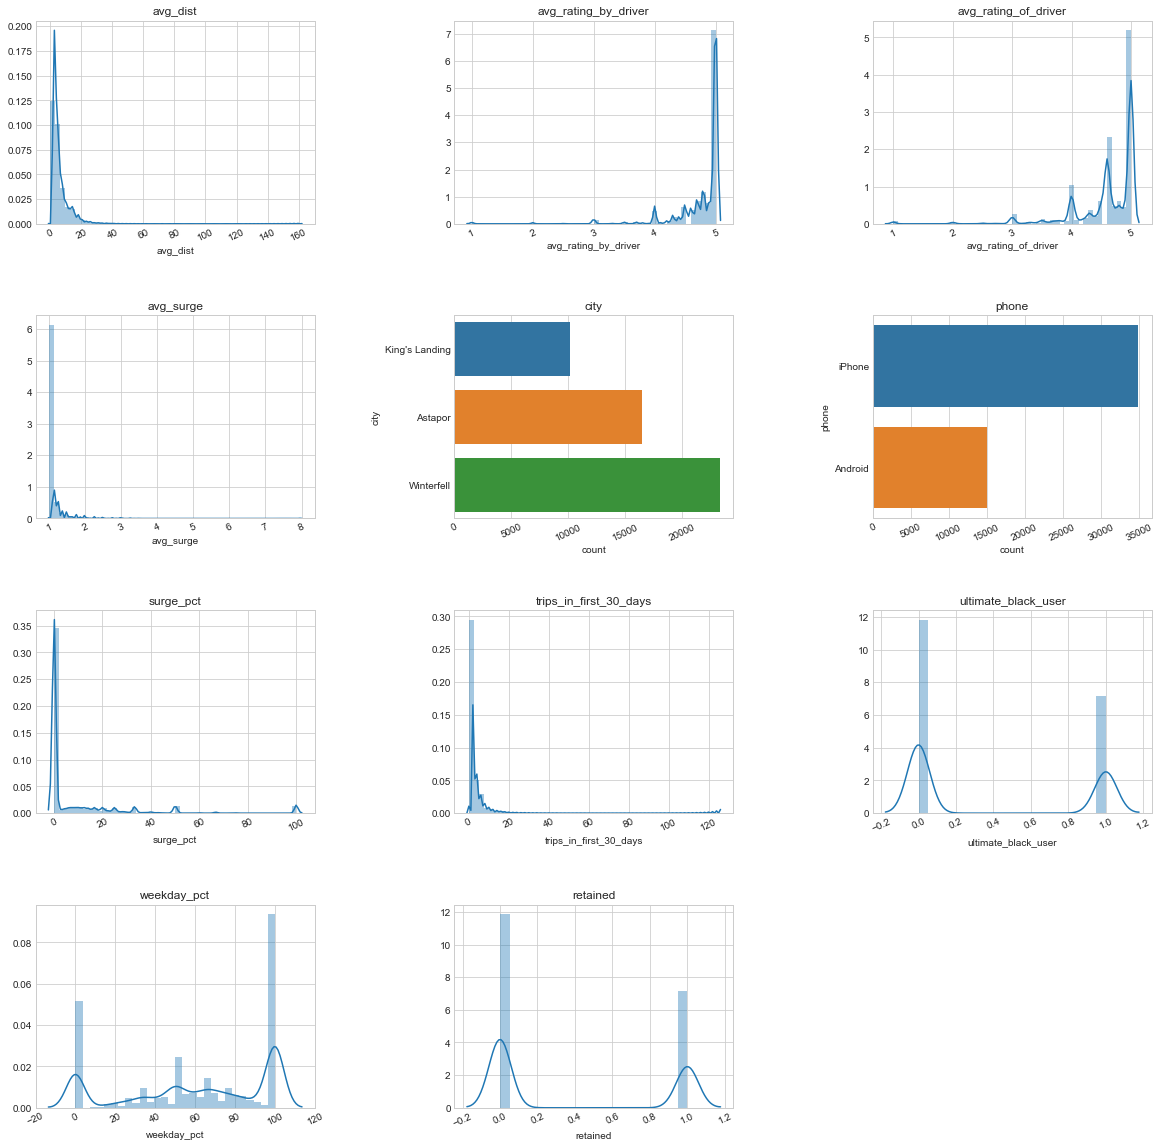

In [43]:
# Let’s plot the distribution of each feature for plot_distribution
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object: #Categorical
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else: #Numerical
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(df, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

### 2.2 Bi-variate Analysis

We notice that iPhone users are much likely to be retained than Android users.
We also observe that the users in the city of Winterfell most retained.
It is so much interesting that **the retained users in the city of King's Landing exceed the non active users.**
In short, the users in the King's Landing city have higher probabilities to be retained.

In [44]:
def intTobool(x):
    if(x==1):
        return True
    elif(x==0):
        return False
    return "error"

# df['ultimate_black_user'] = [1 if x == True else 0 for x in df.ultimate_black_user]
# df['retained'] = [1 if x == True else 0 for x in df.retained]

# # warning - should convert Boolean type to 1,0
# for b in bool_cols:
#     df[b] = df[b].apply(intTobool)

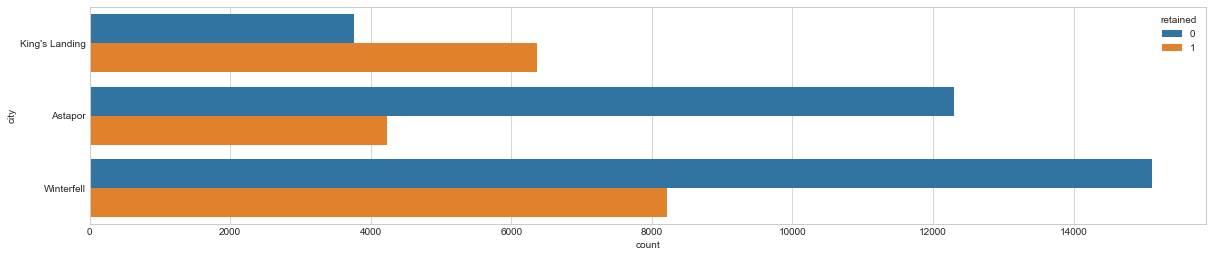

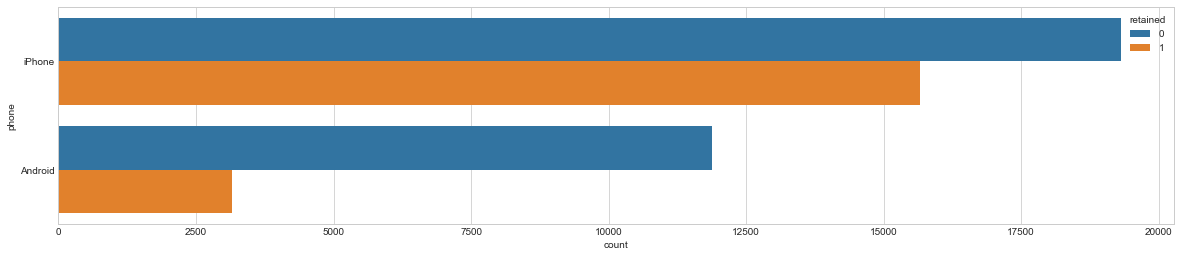

In [45]:
# categorical bi-variate analysis
plt.style.use('seaborn-whitegrid')

for cat in categorical_cols:
    fig = plt.figure(figsize=(20,4)) 
    sns.countplot(y=cat, hue="retained", data=df)

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/pytho

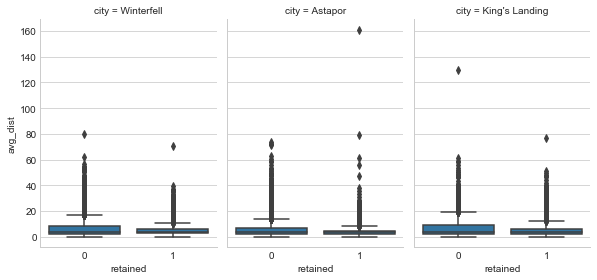

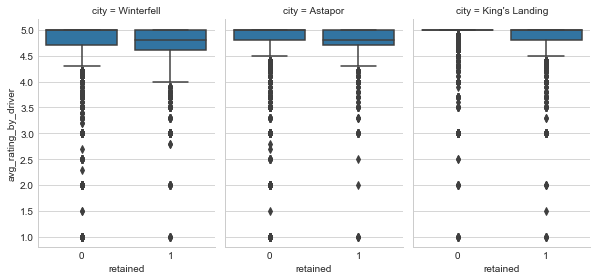

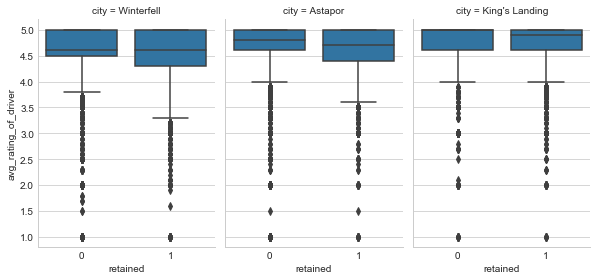

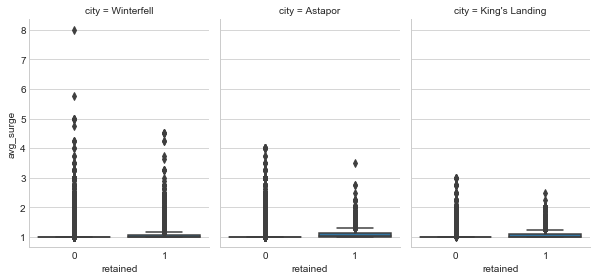

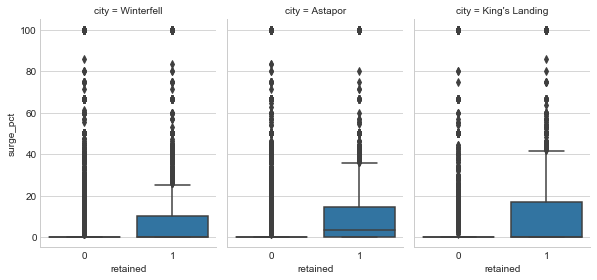

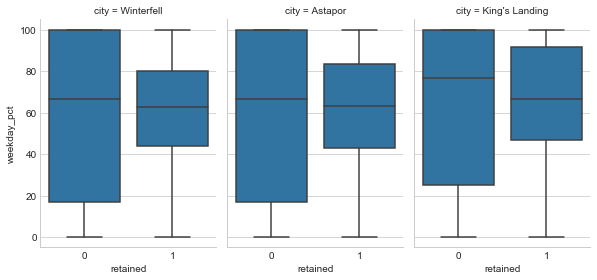

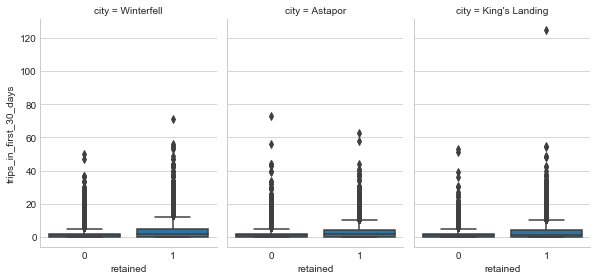

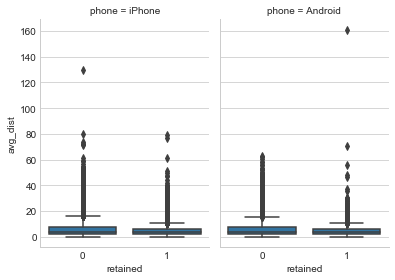

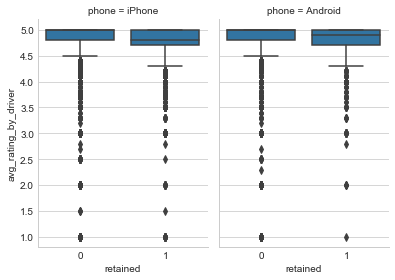

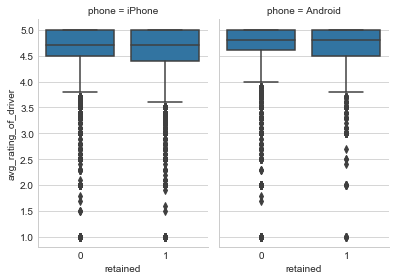

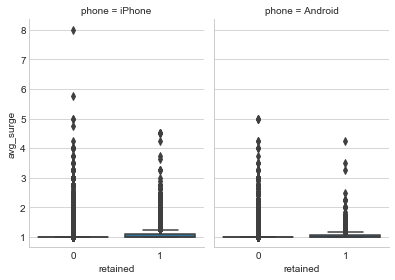

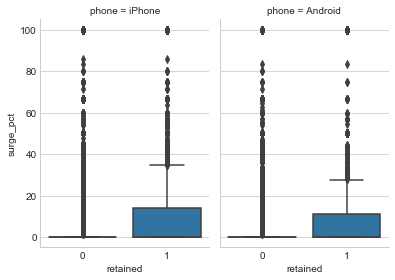

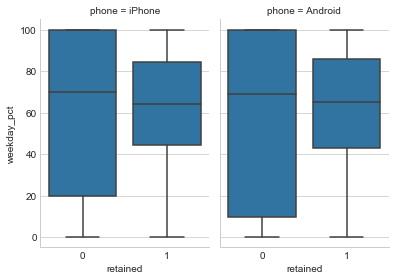

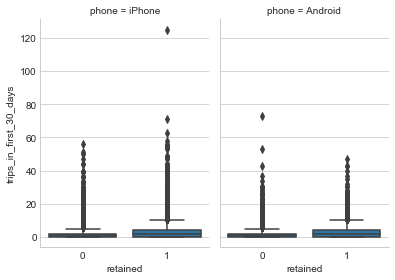

In [46]:
for cat in categorical_cols:
    for num in comb_numeric_cols:
        g = sns.FacetGrid(df, col=cat,height=4, aspect=.7, 
                          col_order=df[cat].value_counts().index, row_order=num)
        g = g.map(sns.boxplot, 'retained', num)

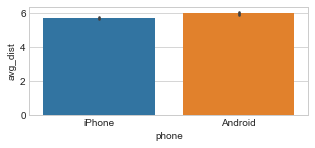

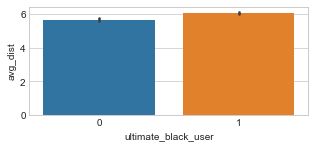

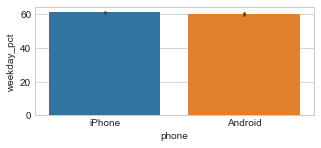

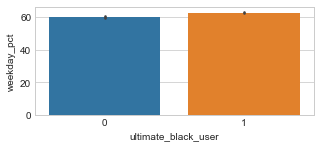

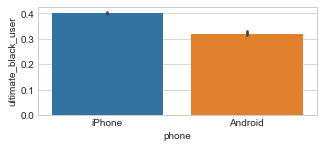

In [47]:
# two variables
fig = plt.figure(figsize=(5,2)) 
sns.barplot(x='phone', y='avg_dist', data=df)

fig = plt.figure(figsize=(5,2)) 
sns.barplot(y='avg_dist', x='ultimate_black_user', data=df)

fig = plt.figure(figsize=(5,2)) 
sns.barplot(x='phone', y='weekday_pct', data=df)

fig = plt.figure(figsize=(5,2)) 
sns.barplot(y='weekday_pct', x='ultimate_black_user', data=df)

fig = plt.figure(figsize=(5,2)) 
sns.barplot(x='phone', y='ultimate_black_user', data=df)

In [48]:
# g = sns.FacetGrid(df, col="phone",  hue='retained')
# g = (g.map(plt.hist, 'trips_in_first_30_days').add_legend())

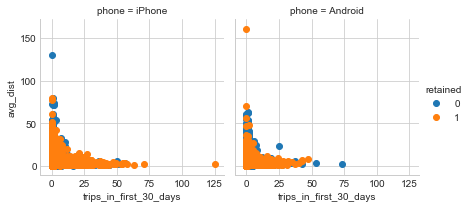

In [49]:
g = sns.FacetGrid(df, col="phone", hue="retained")
g = (g.map(plt.scatter, 'trips_in_first_30_days', 'avg_dist').add_legend())

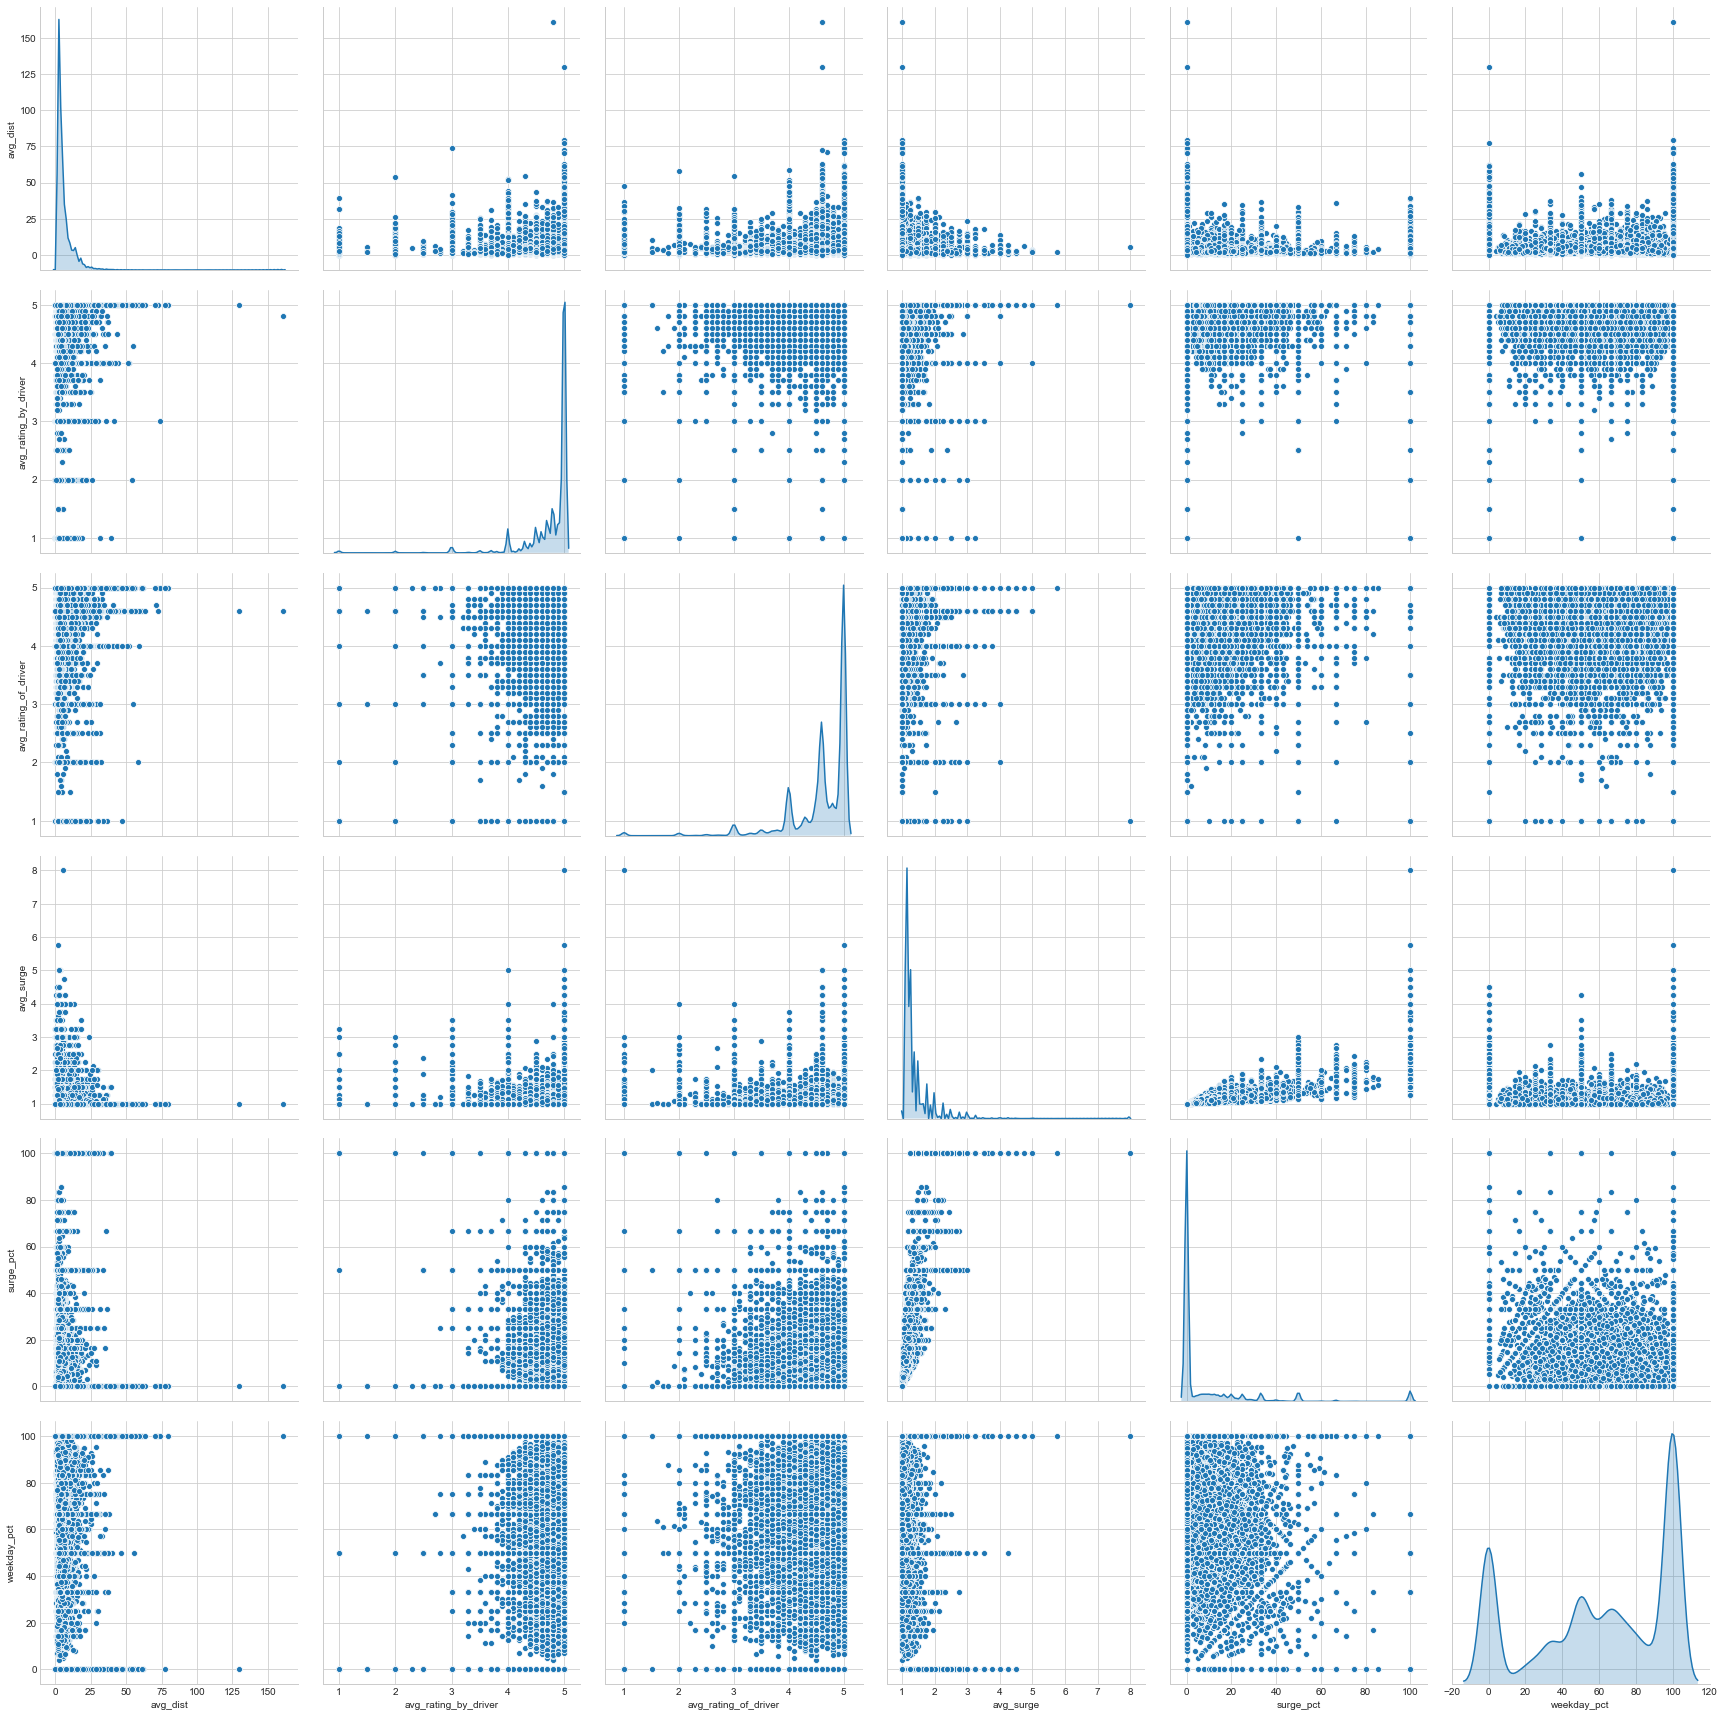

In [50]:
sns.pairplot(df[numeric_cols], 
#             hue="retained", 
             diag_kind="kde",
             height=4);

### 2.3 Feature Encoding

In [51]:
y = df['retained']
X = df.drop('retained', axis=1)

In [52]:
# last check for missing values
print("Number of y: {}".format(len(y)))
df.info()

Number of y: 50000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
dtypes: float64(6), int64(3), object(2)
memory usage: 4.2+ MB


In [53]:
# Pandas get_dummies 
X_encoded_getdummies = pd.get_dummies(X, columns = categorical_cols, prefix_sep='_', drop_first=True) 
#The drop_first=True drops one column from the resulted dummy features. The purpose is to avoid multicollinearity. 

In [54]:
X = X_encoded_getdummies

In [55]:
X.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_King's Landing,city_Winterfell,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,0,1,0


In [56]:
X.shape

(50000, 11)

### 2.4 Feature Selction

#### Feature Correlation

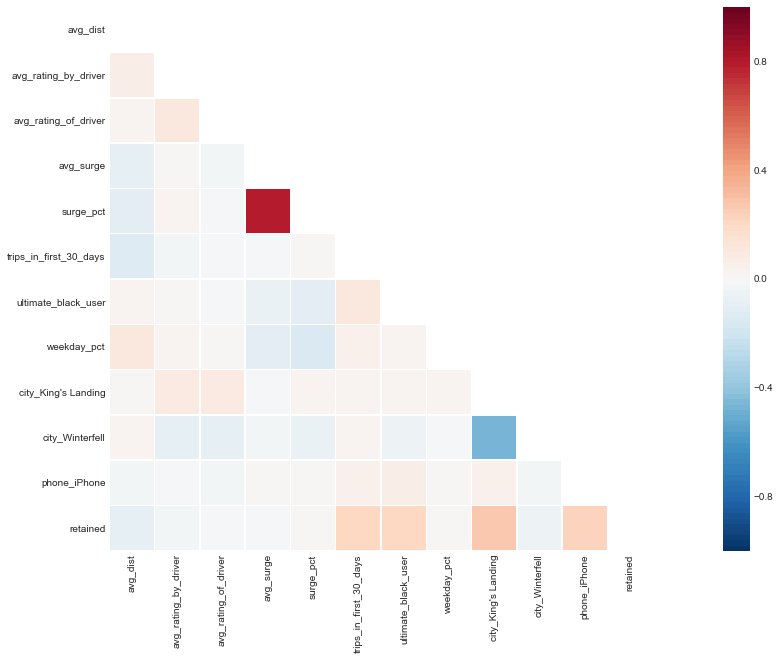

In [57]:
#Create a correlation plot of both datasets.

#corr_Xy = X.join(y)
corr_Xy = pd.concat([X,y], axis=1)

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 

#plt.subplot(1, 2, 1)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_Xy.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_Xy.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5)

#### Feature Importance

Feature ranking:
1. feature 0 (0.31)
2. feature 7 (0.13)
3. feature 1 (0.11)
4. feature 2 (0.08)
5. feature 5 (0.08)
6. feature 3 (0.08)
7. feature 4 (0.07)
8. feature 8 (0.06)
9. feature 10 (0.03)
10. feature 6 (0.03)
11. feature 9 (0.01)


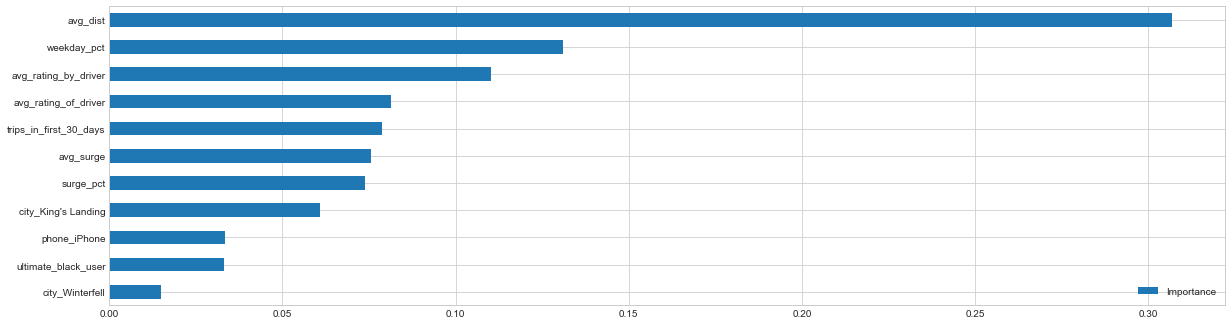

In [58]:
from sklearn.ensemble import RandomForestClassifier

# Using Random Forest to gain an insight on Feature Importance
rfclf = RandomForestClassifier()
rfclf.fit(X, y)

plt.style.use('seaborn-whitegrid')
importances = rfclf.feature_importances_

#####
std = np.std([tree.feature_importances_ for tree in rfclf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%.2f)" % (f + 1, indices[f], importances[indices[f]]))

#####
df_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"])
df_importances.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importances)/2));

In the feature importance analysis, we can find the important features affecting on the target variable of retained users (`retained`). 

- The average distance (`avg_dist`) in the most major important indicator for predicting a retained user.
- The percentage of the user's trips occurring durinng a weekday (`weekday_pct`) and the rider's average rating over all of their trips (`avg_rating_by_driver`) are also important indicators. 
  - The users who has high usages on weekdays may use the Ultimate cars as main vehicles for commuting (or may not own their own cars). 
  - The users who receive the high ratings can be more considered to be engaged in this service. 
  - ==> So, it may be effective to issue the promotional coupons or discounts for highly rated users or high weekday usage users.
- The rest features are also important in the following order.
  - `surge_pct`, `avg_rating_of_driver`, `trips_in_first_30_days`, `avg_surge`, `city_King's Landing`, `phone_iPhone`, `ultimate_black_user`, and `city_Winterfell`

## 3. Predictive Modeling

In [59]:
df = X.join(y)
df.to_csv('data/to_model.csv')

In [60]:
df_copy = df.copy()

### 3.1 Preprocessing
#### StandardScaler before splitting the data into train/test

In [61]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

# set random_state SEED variable
SEED = 42

In [62]:
from sklearn import preprocessing

# create scaler
scaler = preprocessing.StandardScaler()

# transform numeric stats
df_copy[comb_numeric_cols] = scaler.fit_transform(df_copy[comb_numeric_cols])

df_copy.head()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_King's Landing,city_Winterfell,phone_iPhone,retained
0,-0.372650,0.497484,0.174689,0.113506,0.328202,0.453984,1,-0.397131,1,0,1,1
1,0.431583,0.497484,0.705689,-0.336268,-0.443394,-0.600689,0,-0.294653,0,0,0,0
2,-0.880771,0.497484,-0.533312,-0.336268,-0.443394,0.190316,0,1.053741,0,0,1,0
3,-0.602181,0.273144,-0.002312,0.293416,0.558679,1.772325,1,0.514383,1,0,1,1
4,-0.467266,0.273144,-0.356312,0.518303,0.147829,3.090665,0,0.579106,0,1,0,0


Let's take one last peek at our data before we start running Machine Learning algorithms.

In [63]:
# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = SEED)

# training set breakdown
#train_success = y_train.sum()
train_total = len(y_train)
#train_percent = train_success / train_total
print('Training Set\nTotal:\t\t{}'.format(train_total))

# test set breakdown
#test_success = y_test.sum()
test_total = len(y_test)
#test_percent = test_success / test_total
print('Test Set\nTotal:\t\t{}'.format(test_total))

Training Set
Total:		35000
Test Set
Total:		15000


#### Check for balanced data set

Class 0: 31196
Class 1: 18804
Proportion: 2.0 : 1


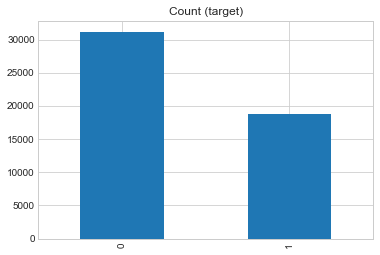

In [64]:
target_count = df.retained.value_counts()
print('Class 0: {}'.format(target_count[0]))
print('Class 1: {}'.format(target_count[1]))
print('Proportion: {}'.format(round(target_count[0] / target_count[1]), 2), ': 1')

target_count.plot(kind='bar', title = 'Count (target)')

# #y : Train set
# target_count = y_train.value_counts()
# print('Class 0: {}'.format(target_count[0]))
# print('Class 1: {}'.format(target_count[1]))
# print('Proportion: {}'.format(round(target_count[0] / target_count[1]), 2), ': 1')
# target_count.plot(kind='bar', title = 'Count (target for Train set)')

# #y : Test set
# target_count = y_test.value_counts()
# print('Class 0: {}'.format(target_count[0]))
# print('Class 1: {}'.format(target_count[1]))
# print('Proportion: {}'.format(round(target_count[0] / target_count[1]), 2), ': 1')
# target_count.plot(kind='bar', title = 'Count (target for Test set)')

In [65]:
# Machine learning 
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
#tree
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

import time
import datetime

In [66]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [67]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, y_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

### 3.3 Algorithms

#### Logistic Regression

In [68]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 40.64 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.719 (std: 0.005)
Parameters: {'penalty': 'l1', 'intercept_scaling': 2.2763326287441016e-08, 'class_weight': None, 'C': 8369360.3893861165}

Model with rank: 1
Mean validation score: 0.719 (std: 0.005)
Parameters: {'penalty': 'l2', 'intercept_scaling': 2.407344000724271e-05, 'class_weight': None, 'C': 1.1368562940935461e+17}

Model with rank: 3
Mean validation score: 0.702 (std: 0.007)
Parameters: {'penalty': 'l2', 'intercept_scaling': 805.9175793352252, 'class_weight': 'balanced', 'C': 500575911676403.7}

Model with rank: 4
Mean validation score: 0.701 (std: 0.008)
Parameters: {'penalty': 'l1', 'intercept_scaling': 1.5846012420414173e+19, 'class_weight': 'balanced', 'C': 7498726237.941964}

Model with rank: 5
Mean validation score: 0.623 (std: 0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1.0275457802869213e+18, 'class_weight': None, 'C': 1375.035248823159

In [69]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, y_test,
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy: 71.56
Accuracy CV 10-Fold: 71.83
Running Time: 0:00:01.341735


In [70]:
print(metrics.classification_report(y_train, train_pred_log))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     21817
           1       0.67      0.49      0.57     13183

   micro avg       0.72      0.72      0.72     35000
   macro avg       0.70      0.67      0.68     35000
weighted avg       0.71      0.72      0.71     35000



In [71]:
print(metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      9379
           1       0.66      0.50      0.57      5621

   micro avg       0.72      0.72      0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



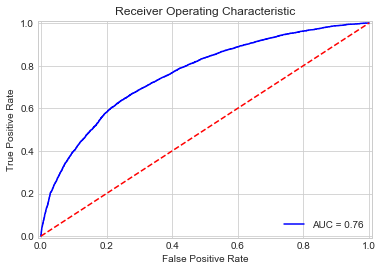

In [72]:
plot_roc_curve(y_test, probs_log)

#### k-Nearest Neighbors

In [73]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, y_test,
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 72.91
Accuracy CV 10-Fold: 73.21
Running Time: 0:00:02.692640


In [74]:
print(metrics.classification_report(y_train, train_pred_knn))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79     21817
           1       0.65      0.61      0.63     13183

   micro avg       0.73      0.73      0.73     35000
   macro avg       0.71      0.71      0.71     35000
weighted avg       0.73      0.73      0.73     35000



In [75]:
print(metrics.classification_report(y_test, test_pred_knn))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      9379
           1       0.64      0.62      0.63      5621

   micro avg       0.73      0.73      0.73     15000
   macro avg       0.71      0.71      0.71     15000
weighted avg       0.73      0.73      0.73     15000



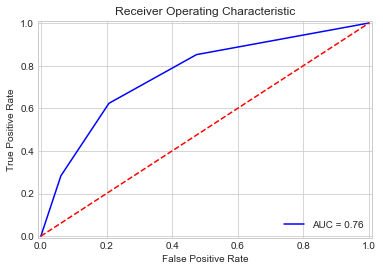

In [76]:
plot_roc_curve(y_test, probs_knn)

#### Decision Tree Classifier

In [77]:
# Decision Tree Classifier
start_time = time.time()

def fit_ml_algo_clf(algo, X_train, y_train, X_test, y_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs, model

train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt, clf_obj = fit_ml_algo_clf(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, y_test,
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 69.59
Accuracy CV 10-Fold: 70.72
Running Time: 0:00:00.609093


In [78]:
print(metrics.classification_report(y_train, train_pred_dt))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77     21817
           1       0.61      0.61      0.61     13183

   micro avg       0.71      0.71      0.71     35000
   macro avg       0.69      0.69      0.69     35000
weighted avg       0.71      0.71      0.71     35000



In [79]:
print(metrics.classification_report(y_test, test_pred_dt))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      9379
           1       0.59      0.59      0.59      5621

   micro avg       0.70      0.70      0.70     15000
   macro avg       0.68      0.68      0.68     15000
weighted avg       0.70      0.70      0.70     15000



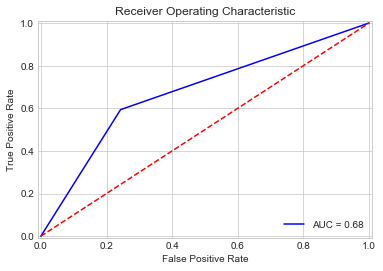

In [80]:
plot_roc_curve(y_test, probs_dt)

In [81]:
# # Visualization
# features = list(X_train.columns)
# targets = ['No retained', 'Retained']
# dot_data = tree.export_graphviz(clf_obj, out_file=None, feature_names=features, class_names=targets, 
#                                 filled=True, rounded=True, special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph

#### Random Forest Classifier

In [82]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 2.59 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.783 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.782 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 8}

Model with rank: 3
Mean validation score: 0.781 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 14}

Model with rank: 4
Mean validation score: 0.780 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 9, 'min_samples_split': 2}

Model with rank: 5
Mean validation score: 0.779 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_

In [83]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, y_test,
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 76.56
Accuracy CV 10-Fold: 77.37
Running Time: 0:00:02.177991


In [84]:
print(metrics.classification_report(y_train, train_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82     21817
           1       0.72      0.65      0.68     13183

   micro avg       0.77      0.77      0.77     35000
   macro avg       0.76      0.75      0.75     35000
weighted avg       0.77      0.77      0.77     35000



In [85]:
print(metrics.classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      9379
           1       0.71      0.64      0.67      5621

   micro avg       0.77      0.77      0.77     15000
   macro avg       0.75      0.74      0.74     15000
weighted avg       0.76      0.77      0.76     15000



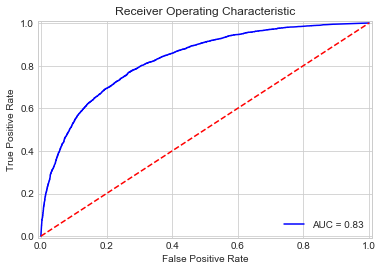

In [86]:
plot_roc_curve(y_test, probs_rf)

#### Gradient Boosting Trees

In [87]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, y_test,                                                                            
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 78.17
Accuracy CV 10-Fold: 78.78
Running Time: 0:00:09.019466


In [88]:
print(metrics.classification_report(y_train, train_pred_gbt))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84     21817
           1       0.74      0.67      0.70     13183

   micro avg       0.79      0.79      0.79     35000
   macro avg       0.78      0.76      0.77     35000
weighted avg       0.79      0.79      0.79     35000



In [89]:
print(metrics.classification_report(y_test, test_pred_gbt))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      9379
           1       0.73      0.66      0.69      5621

   micro avg       0.78      0.78      0.78     15000
   macro avg       0.77      0.76      0.76     15000
weighted avg       0.78      0.78      0.78     15000



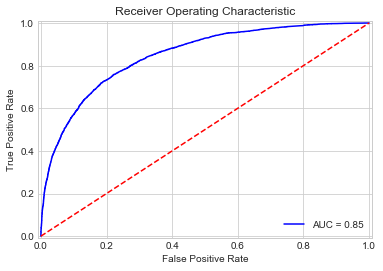

In [90]:
plot_roc_curve(y_test, probs_gbt)

### 3.4 Results

#### Train andn test split

In [91]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Accuracy': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
4,Gradient Boosting Trees,78.17
2,Random Forest,76.56
0,KNN,72.91
1,Logistic Regression,71.56
3,Decision Tree,69.59


#### 10-Fold CV

In [92]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Accuracy (10-fold CV)': [
        acc_cv_knn, 
        acc_cv_log, 
        acc_cv_rf, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Accuracy (10-fold CV)', ascending=False)

,Model,Accuracy (10-fold CV)
4,Gradient Boosting Trees,78.78
2,Random Forest,77.37
0,KNN,73.21
1,Logistic Regression,71.83
3,Decision Tree,70.72


## 4. Conclusion

We have performed two methods of the [feature selection](#2.4-Feature-Selction).

In the [feature correlation](#Feature-Correalation), we have drawn the heat map and found that **there are strong correlation between surge percent and average surge.**

In the [feature impotance analysis](#Feature-Importance), we use inbuilt class `feature_importances` of tree based classifiers (e.g., *RandomForestClassifier*).
In the feature importance analysis, we can find the important features affecting on the target variable of retained users (`retained`). 

- The average distance (`avg_dist`) in the most major important indicator for predicting a retained user.
- The percentage of the user's trips occurring durinng a weekday (`weekday_pct`) and the rider's average rating over all of their trips (`avg_rating_by_driver`) are also important indicators. 
  - The users who has high usages on weekdays may use the Ultimate cars as main vehicles for commuting (or may not own their own cars). 
  - The users who receive the high ratings can be more considered to be engaged in this service. 
  - ==> So, it may be effective to issue the promotional coupons or discounts for highly rated users or high weekday usage users.
- The rest features are also important in the following order.
  - `surge_pct`, `avg_rating_of_driver`, `trips_in_first_30_days`, `avg_surge`, `city_King's Landing`, `phone_iPhone`, `ultimate_black_user`, and `city_Winterfell`
    
For the [model results](#Results),
we obtain the best accuracy in the Gradient Boosting Trees model (Accuracy in 10-fold CV: 78.78). The accuracy needs to be improved using more rich data and features.

# Reference

http://benalexkeen.com/resampling-time-series-data-with-pandas/  
https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

In [93]:
# print(metrics.classification_report(y_train, train_pred_rf))
# print(metrics.classification_report(y_test, test_pred_rf))
# plot_roc_curve(y_test, probs_rf)